In [1]:
import anndata as ad
import scanpy as sc

PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_single_cell__label_cell_type__processed.h5ad'

adata_predict = ad.read_h5ad(PATH)
nbins = adata_predict.uns['nbins']
results = adata_predict.uns['results']
# sc.tl.dendrogram(adata_predict, groupby="label", use_rep="X")

In [2]:
adata_predict

AnnData object with n_obs × n_vars = 144885 × 5792
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'label', 'n_genes', 'train', 'marker_gene', 'marker_feature_name'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'column_1', 'column_2', 'column_3', 'column_4', 'external_gene_name', 'gene_biotype', 'train'
    uns: 'nbins', 'preprocessing', 'rank_genes_groups', 'results', 'var_embedding_pca'
    varm: 'embedding', 'embedding_pca'
    layers: 'confidence', 'measured', 'predicted'

In [3]:
print(
    f"""
    mean spearmanr across genes {results['spearmanr_across_genes_mean']:.3f}
    mean spearmanr across cells {results['spearmanr_across_cells_mean']:.3f}
    mean square error {results['mse']:.3f}
    ks-statistic on total expression {results['ks_statistic']:.3f}
    mean percent total expression captured per cell {results['total_expression_captured']:.3f}
    """
)

if nbins is not None:
    print(
        f"""
        accuracy {results['accuracy_score']:.3f}
        precision {results['precision']:.3f}
        recall {results['recall']:.3f}
        fscore {results['fscore']:.3f}
        """
    )  


    mean spearmanr across genes 0.211
    mean spearmanr across cells 0.063
    mean square error 3.161
    ks-statistic on total expression 0.090
    mean percent total expression captured per cell 257.484
    

        accuracy 0.856
        precision 0.083
        recall 0.083
        fscore 0.071
        


Global seed set to 0


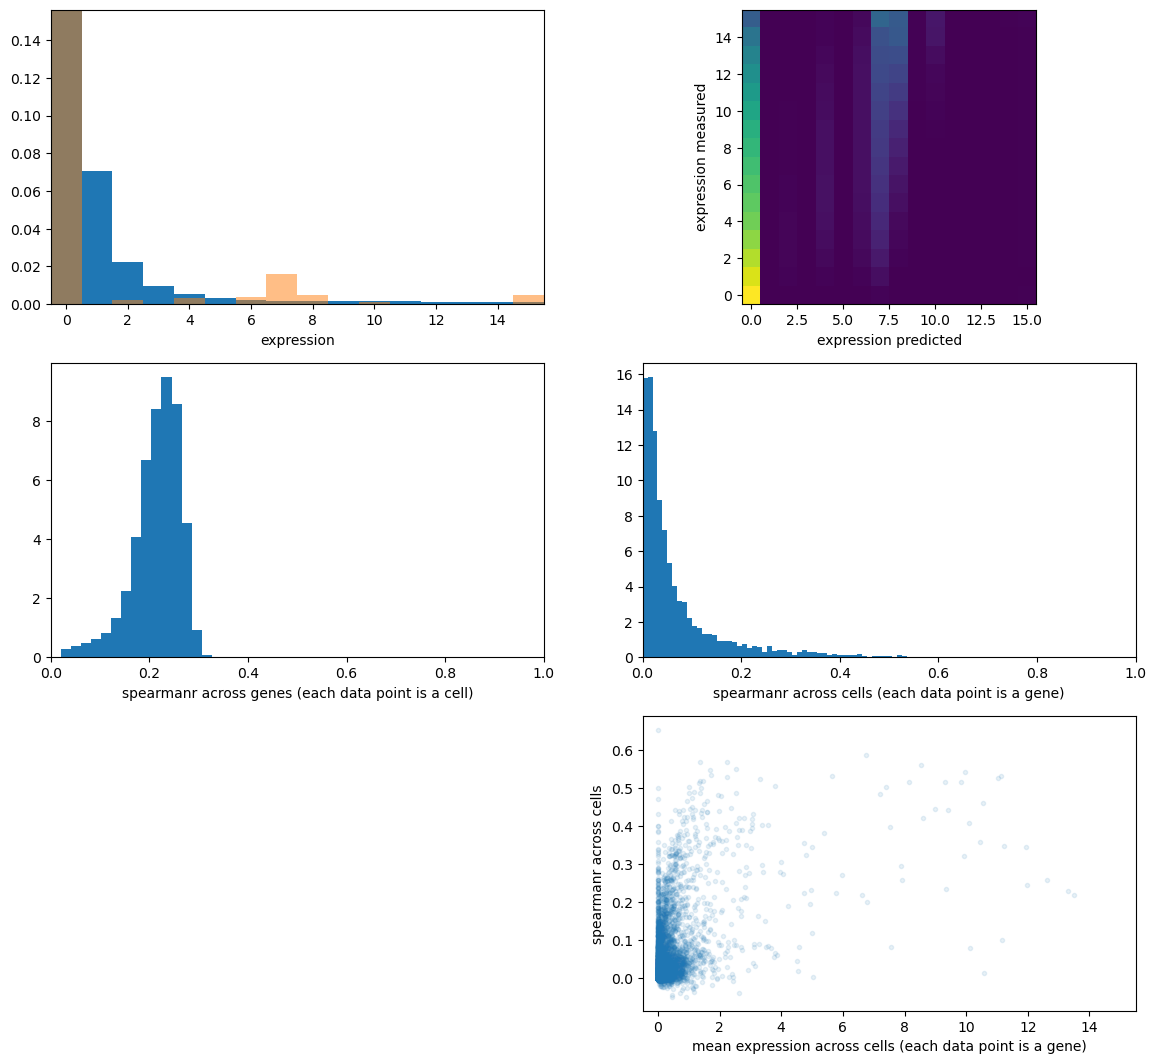

In [4]:
from rosa.utils import plot_expression_and_correlation, plot_marker_gene_heatmap

if nbins is not None:
    mev = nbins - 1
else:
    mev = 6
    
plot_expression_and_correlation(adata_predict, results, max_expression_val=mev, nbins=nbins)

         Falling back to preprocessing with `sc.pp.pca` and default params.


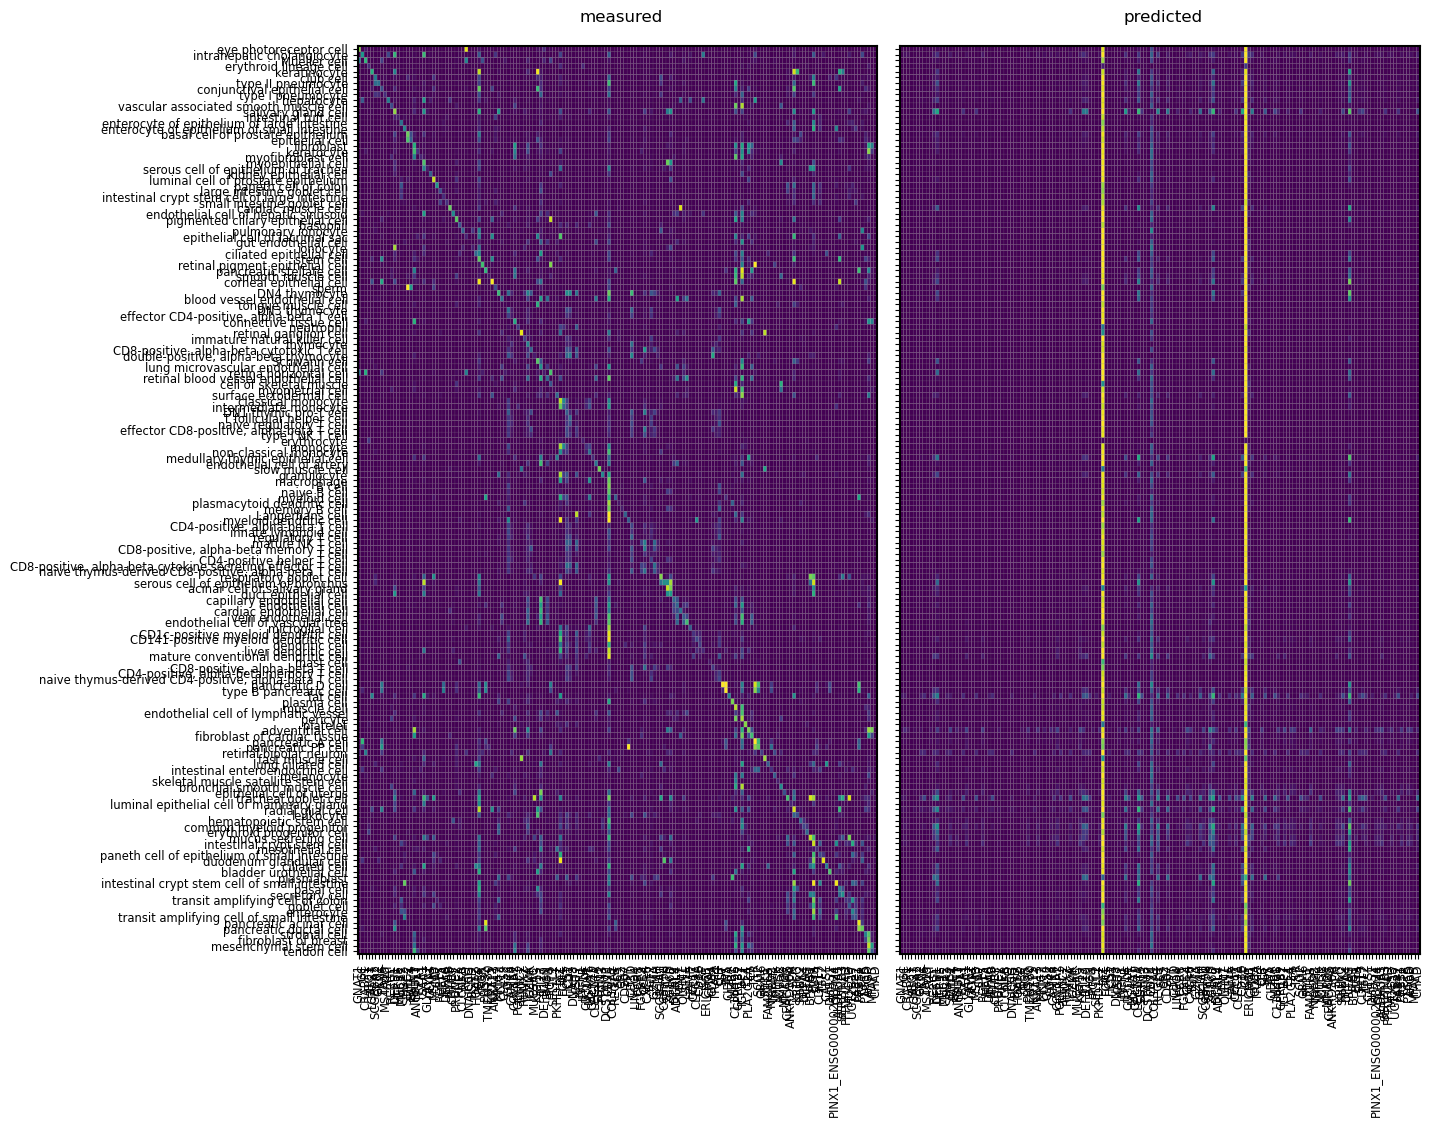

In [5]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_predict, marker_genes_dict, max_expression_val=mev)

## Extras

In [14]:
# import seaborn as sns
# from scipy.cluster.hierarchy import linkage
# import sys


# sys.setrecursionlimit(100000)

In [15]:
# row_linkage = linkage(adata_predict.layers['measured']) # D being the measurement
# col_linkage = linkage(adata_predict.layers['measured'].T) # D being the measurement
# sns.clustermap(adata_predict.layers['measured'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['predicted'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['confidence'], row_linkage=row_linkage, col_linkage=col_linkage)

## Value histograms

In [94]:
import numpy as np

In [95]:
values, counts = np.unique(adata_predict.layers['measured'], return_counts=True)

In [77]:
import matplotlib.pyplot as plt

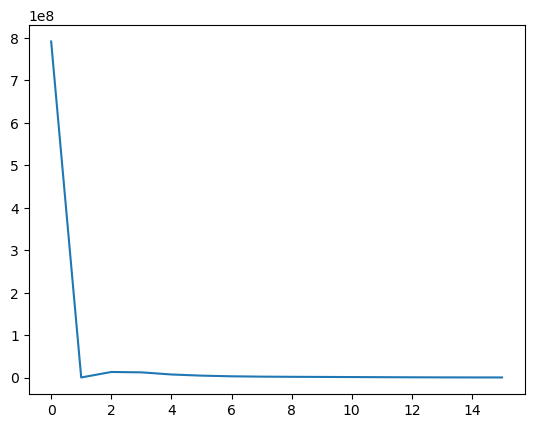

In [96]:
plt.plot(values, counts)

In [97]:
values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [98]:
counts

array([791587747,     67083,  13016518,  12170834,   7124647,   4404861,
         2840390,   2038664,   1631948,   1345576,   1058526,    763865,
          500468,    314640,    179763,    128390])

In [99]:
import torch

In [255]:
from tqdm import tqdm

In [256]:
full_binned = []
full_boundaries = []

n_bins = 16
for i, row in tqdm(enumerate(adata_predict.X)):
    tensor = torch.Tensor(row.toarray())

    boundaries = [torch.tensor(0.0)]
    for q in range(n_bins - 1):
        data_remaining = tensor[tensor>boundaries[-1]]
        n_data_remaining = len(data_remaining)
        if n_data_remaining == 0:
            next_val = boundaries[-1]
        else:
            n_bins_remaining = n_bins - q - 1
            next_quantile = 1 / n_bins_remaining
            next_val = max(boundaries[-1] + 1, torch.quantile(data_remaining, next_quantile))
        boundaries.append(next_val)
    boundaries = torch.stack(boundaries, dim=0)

    full_binned.append(torch.bucketize(tensor, boundaries))
    full_boundaries.append(boundaries)
full_binned = torch.cat(full_binned, dim=0)
full_boundaries = torch.stack(full_boundaries)

144885it [05:07, 471.65it/s]


In [257]:
full_boundaries[12]

tensor([  0.0000,   1.0000,   2.0000,   3.0000,   4.0000,   5.0000,   6.0000,
          7.2222,   9.0000,  22.4286,  35.0000,  90.6000, 169.0000, 214.6667,
        218.0000, 218.0000])

In [258]:
full_boundaries[:, -1]

tensor([ 351.,  224.,  156.,  ..., 3575., 1765., 4032.])

In [259]:
values, counts = torch.unique(full_binned, return_counts=True)

In [260]:
print(values)
print(counts)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
tensor([732581337,  59077041,  18805738,   8246620,   4484012,   2849167,
          2062722,   1692213,   1551275,   1412748,   1268800,   1171751,
          1094037,   1026391,    962031,    888037])


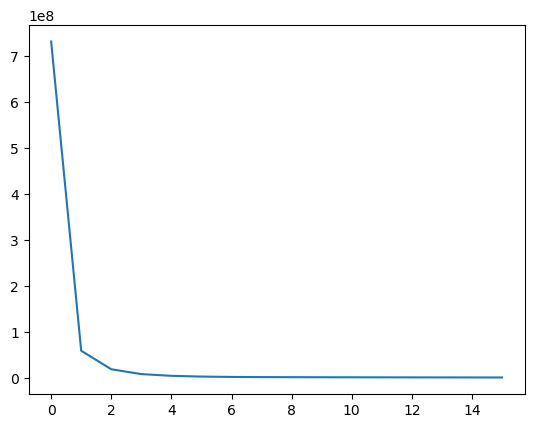

In [261]:
plt.plot(values, counts)

In [ ]:
values, counts = torch.unique(expression, return_counts=True)
nbins = self.transform[-1].n_bins
bin_counts = torch.zeros(nbins, dtype=torch.long)
bin_counts[values] = counts
mask_indices = torch.multinomial(1 / bin_counts[expression], int(self.mask * len(expression)))
mask = torch.zeros(expression.shape, dtype=torch.bool)
mask[mask_indices] = True

mask_type = torch.rand(1)
if mask_type < self.pass_through:
    pass
elif mask_type < self.corrupt:
    count_inds = torch.multinomial(counts, len(mask_indices))
    expression[mask] = values[count_inds]

In [266]:
if torch.rand(1) < 0.3:
    print('a')

## Scanpy plots

In [35]:
import scanpy as sc

In [6]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']

{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

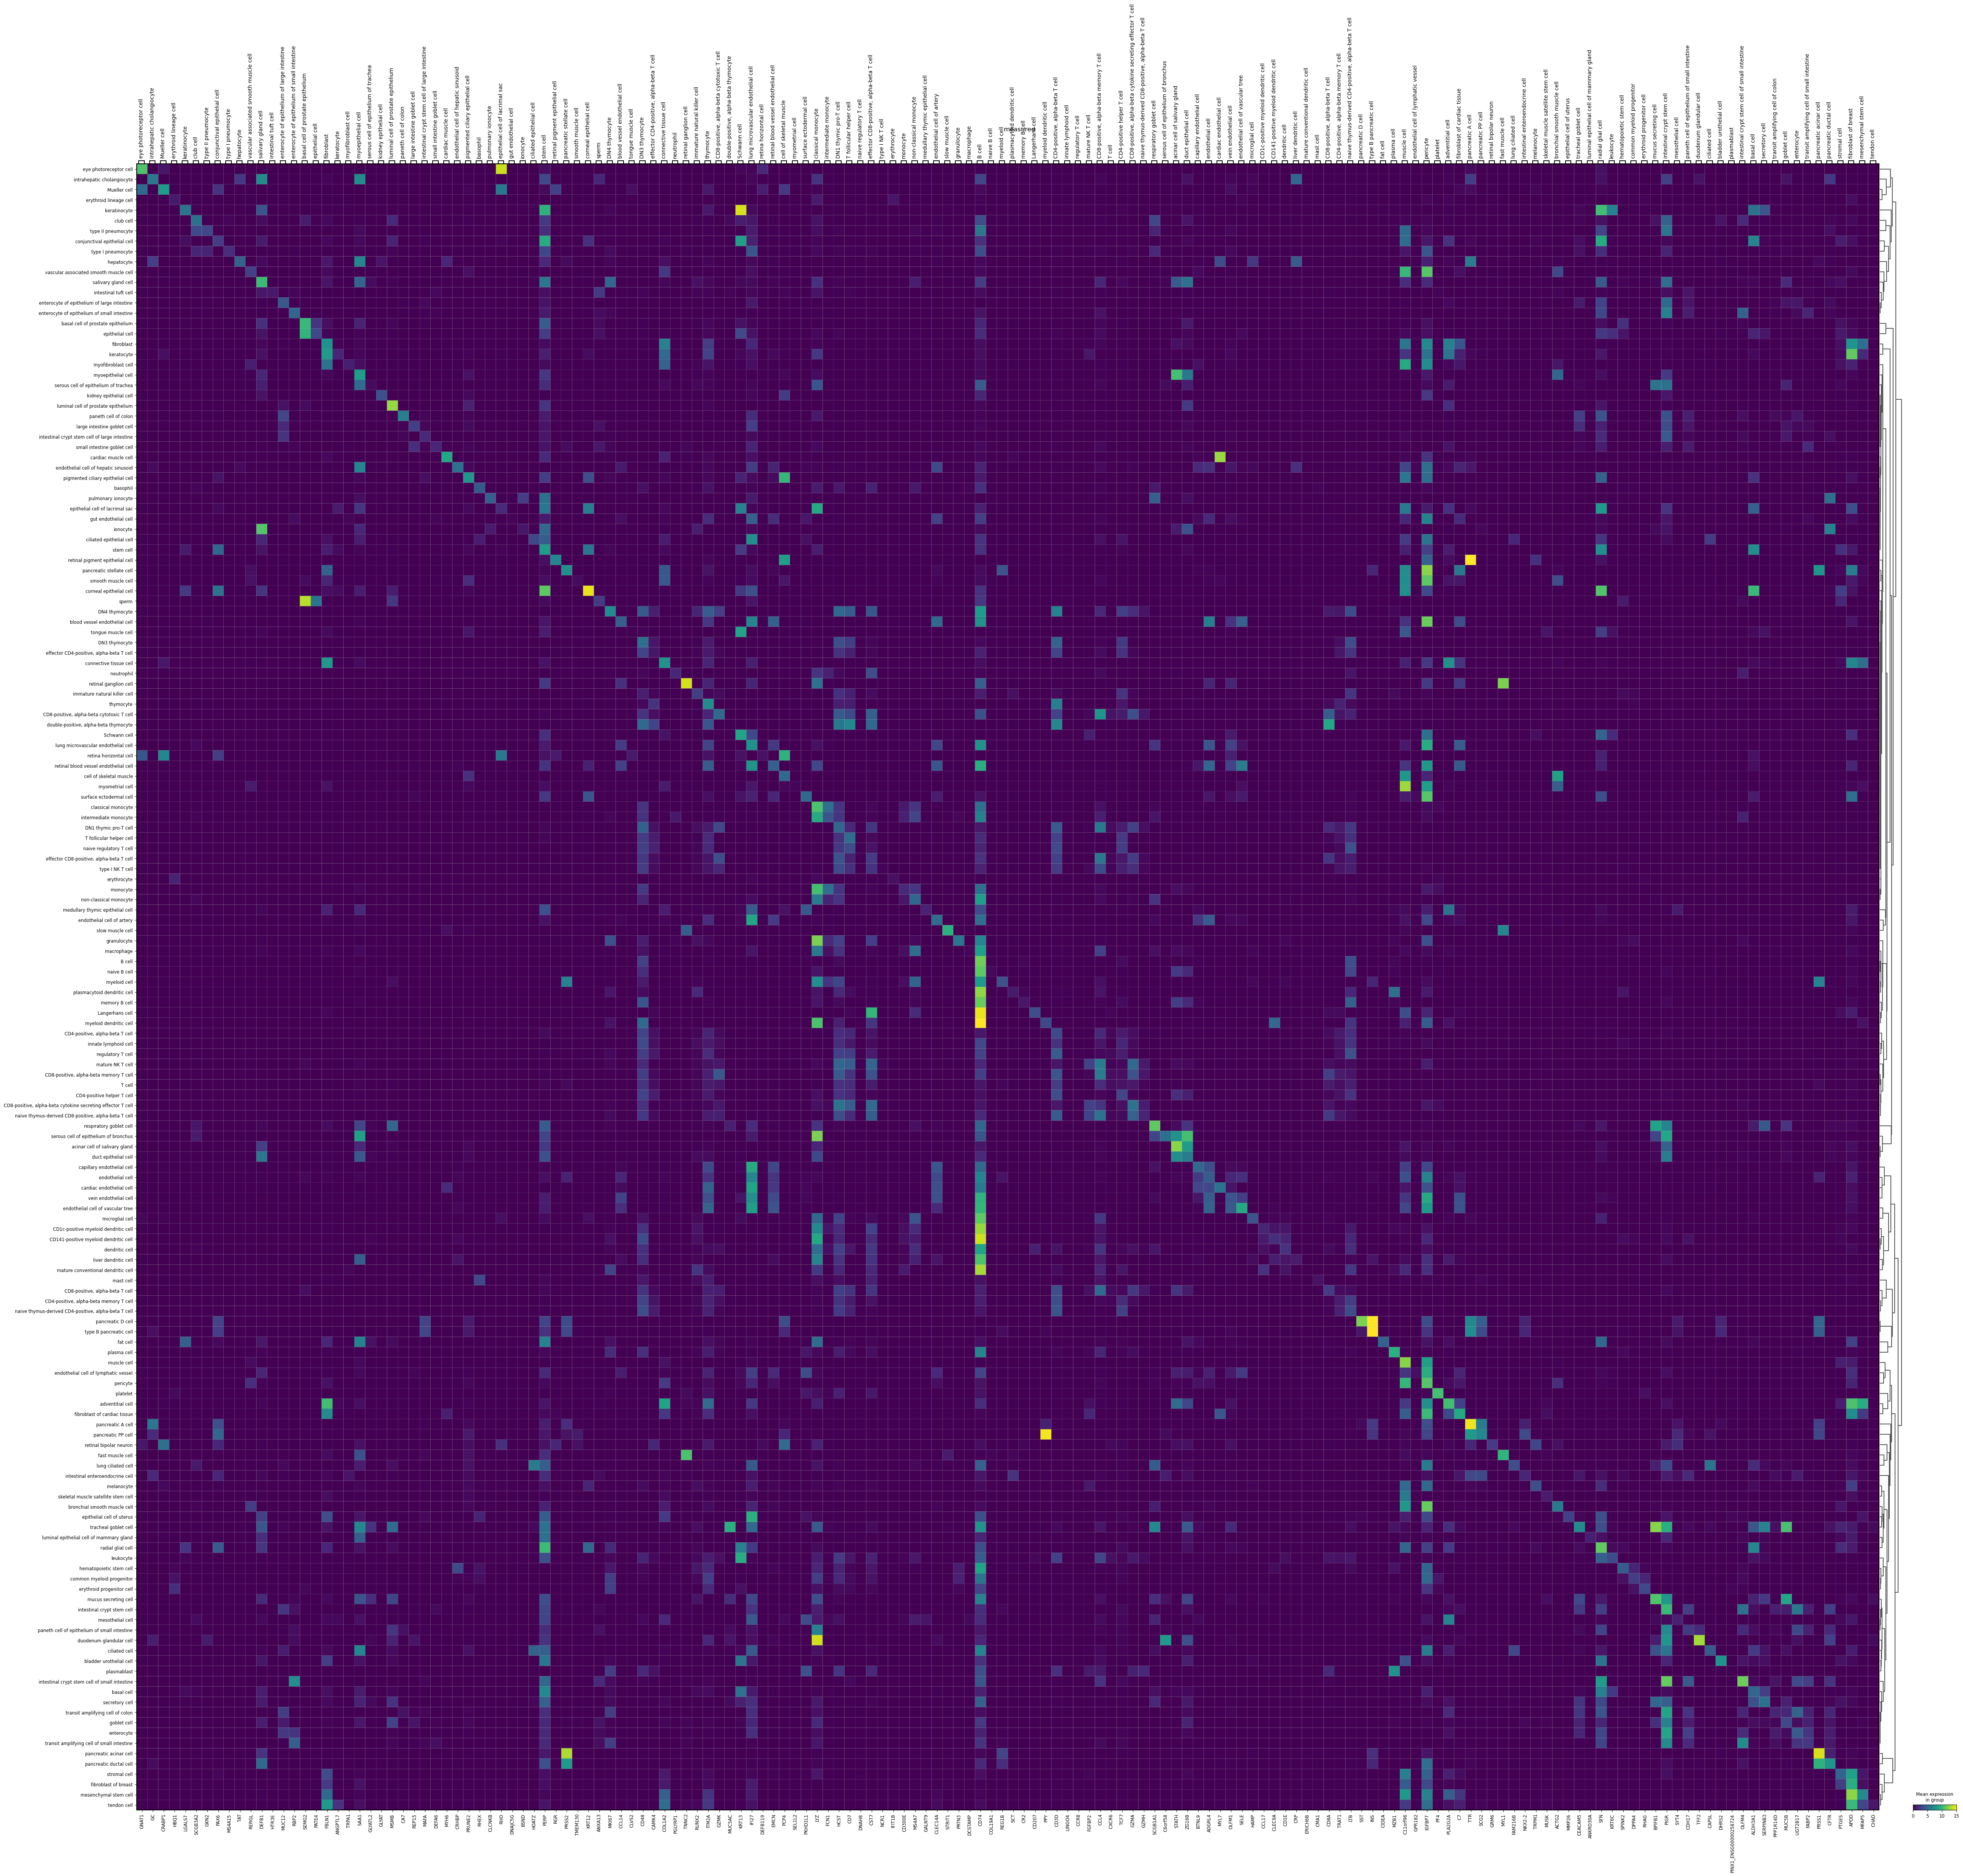

In [85]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

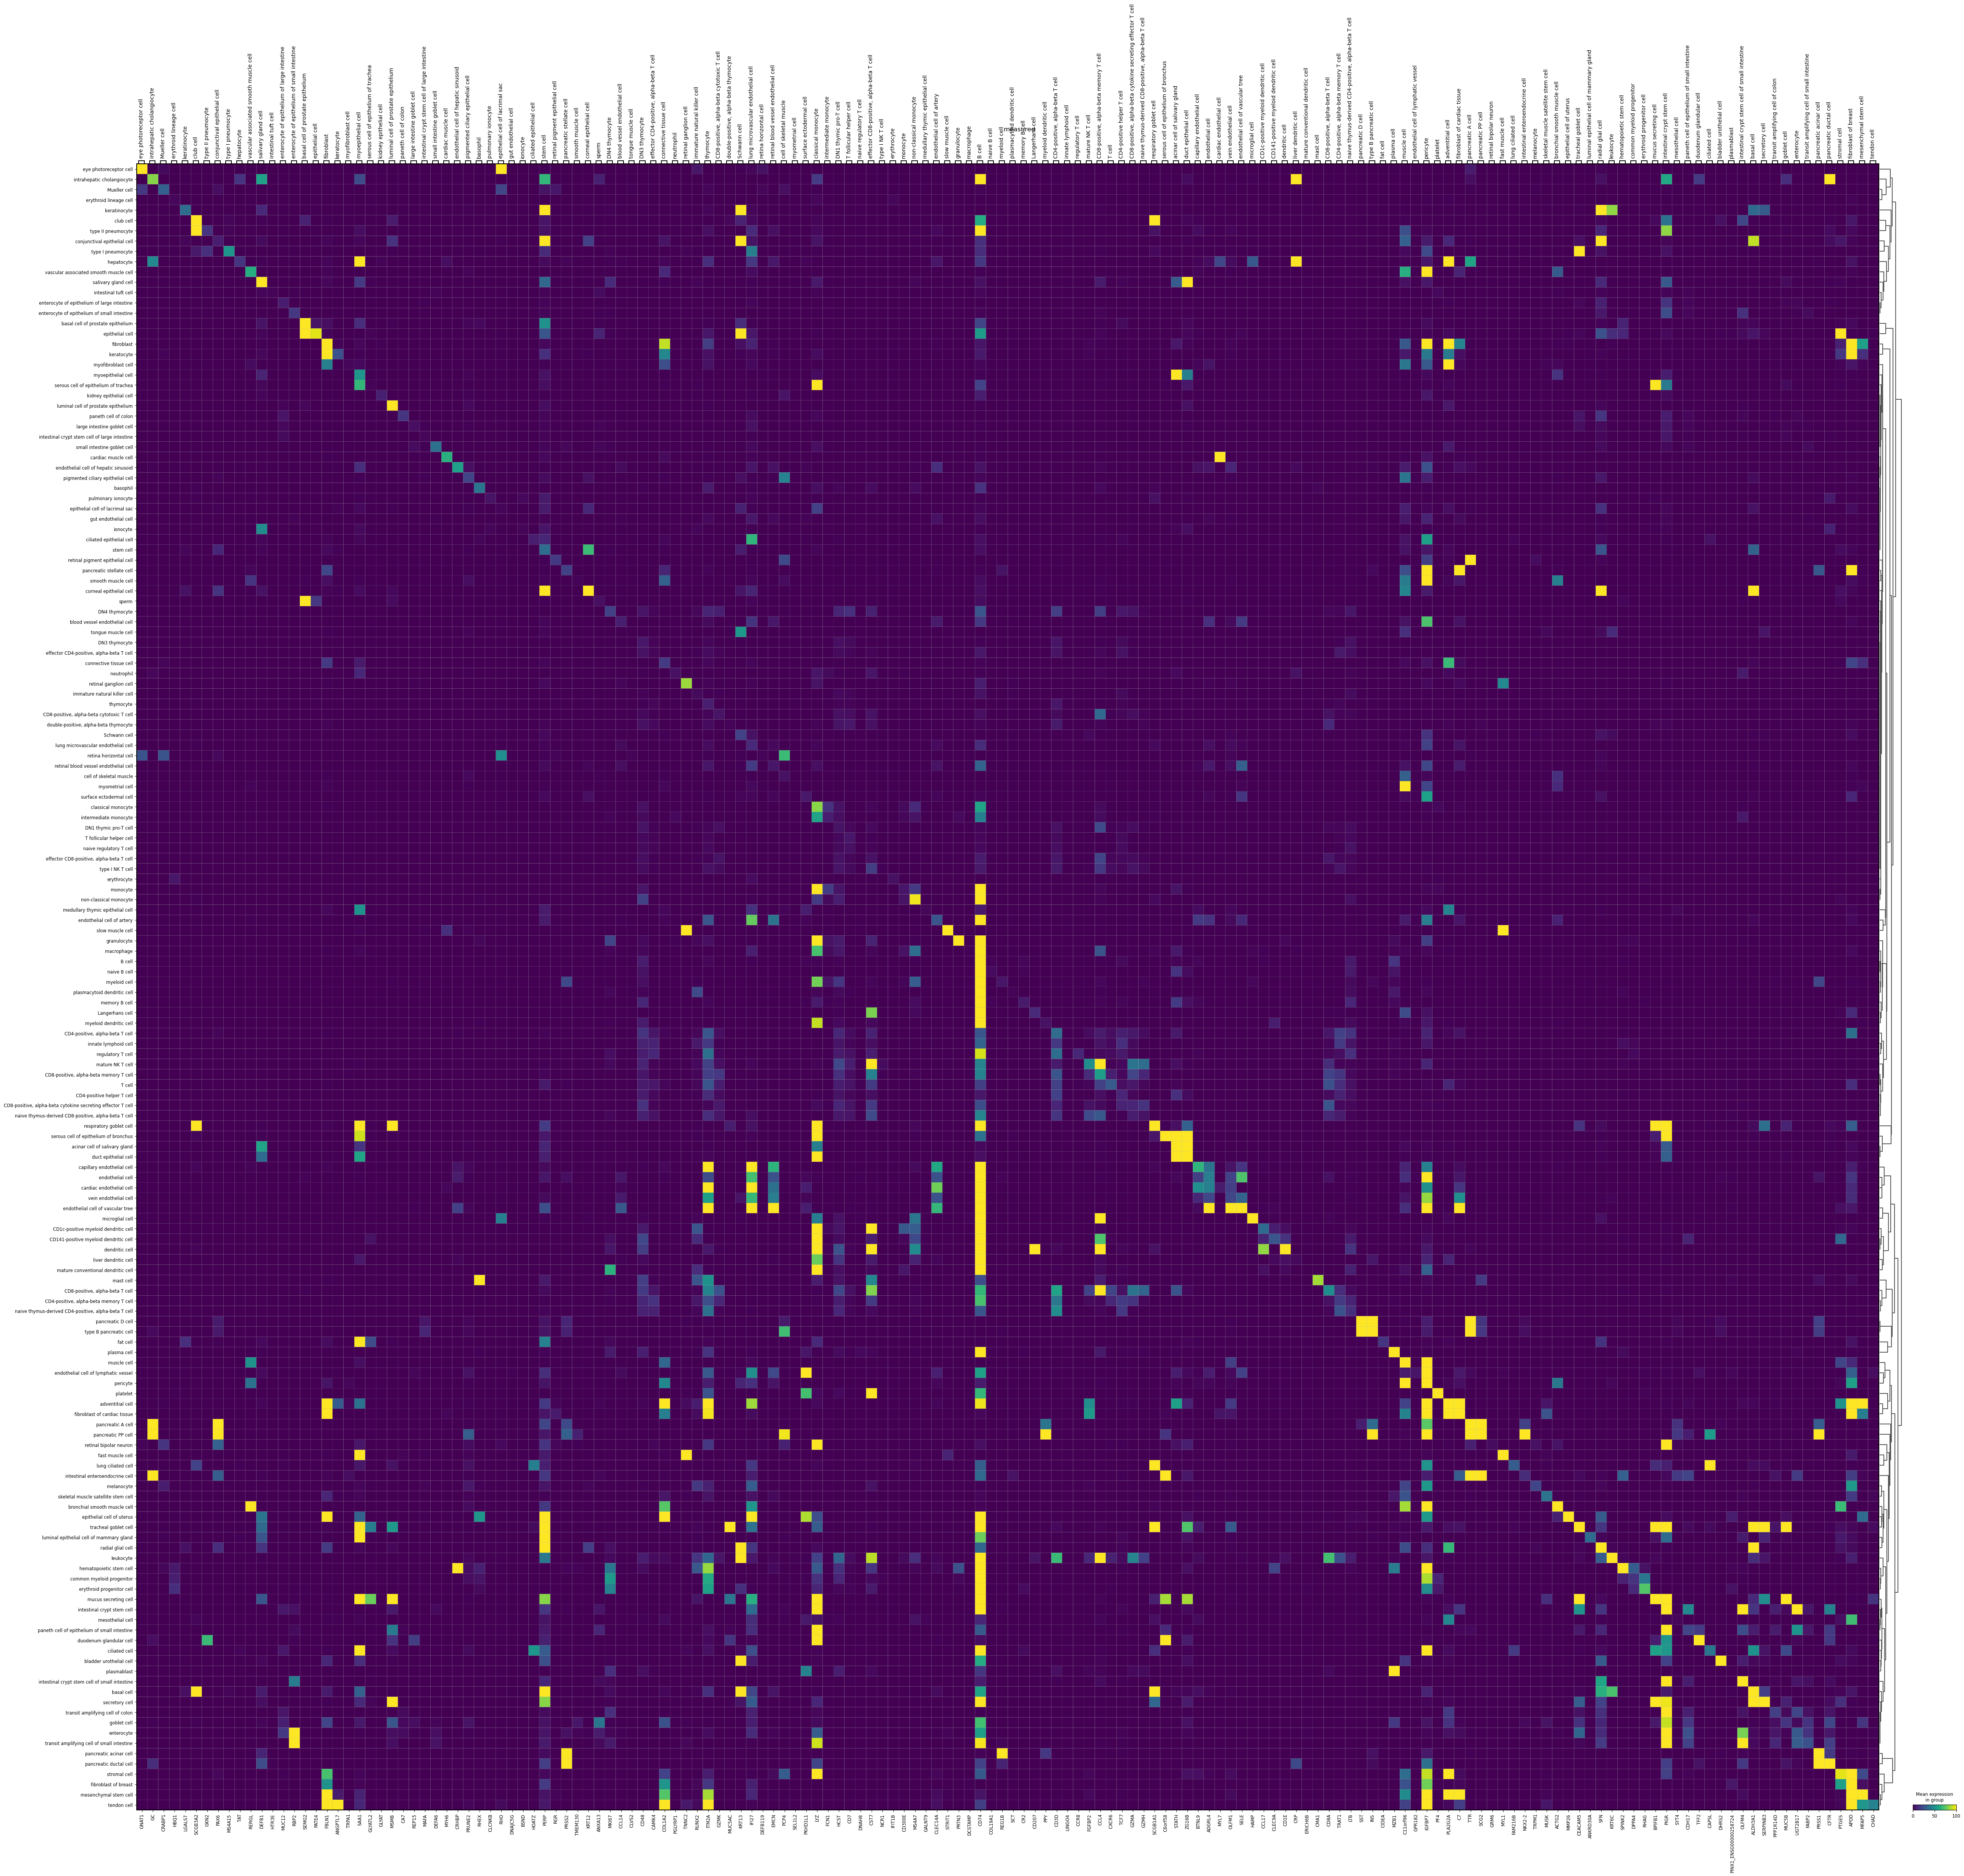

In [226]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer=None,
    vmin=0,
    vmax=1e2,
    show=False,
    title='measured',
    dendrogram=True,
)

{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

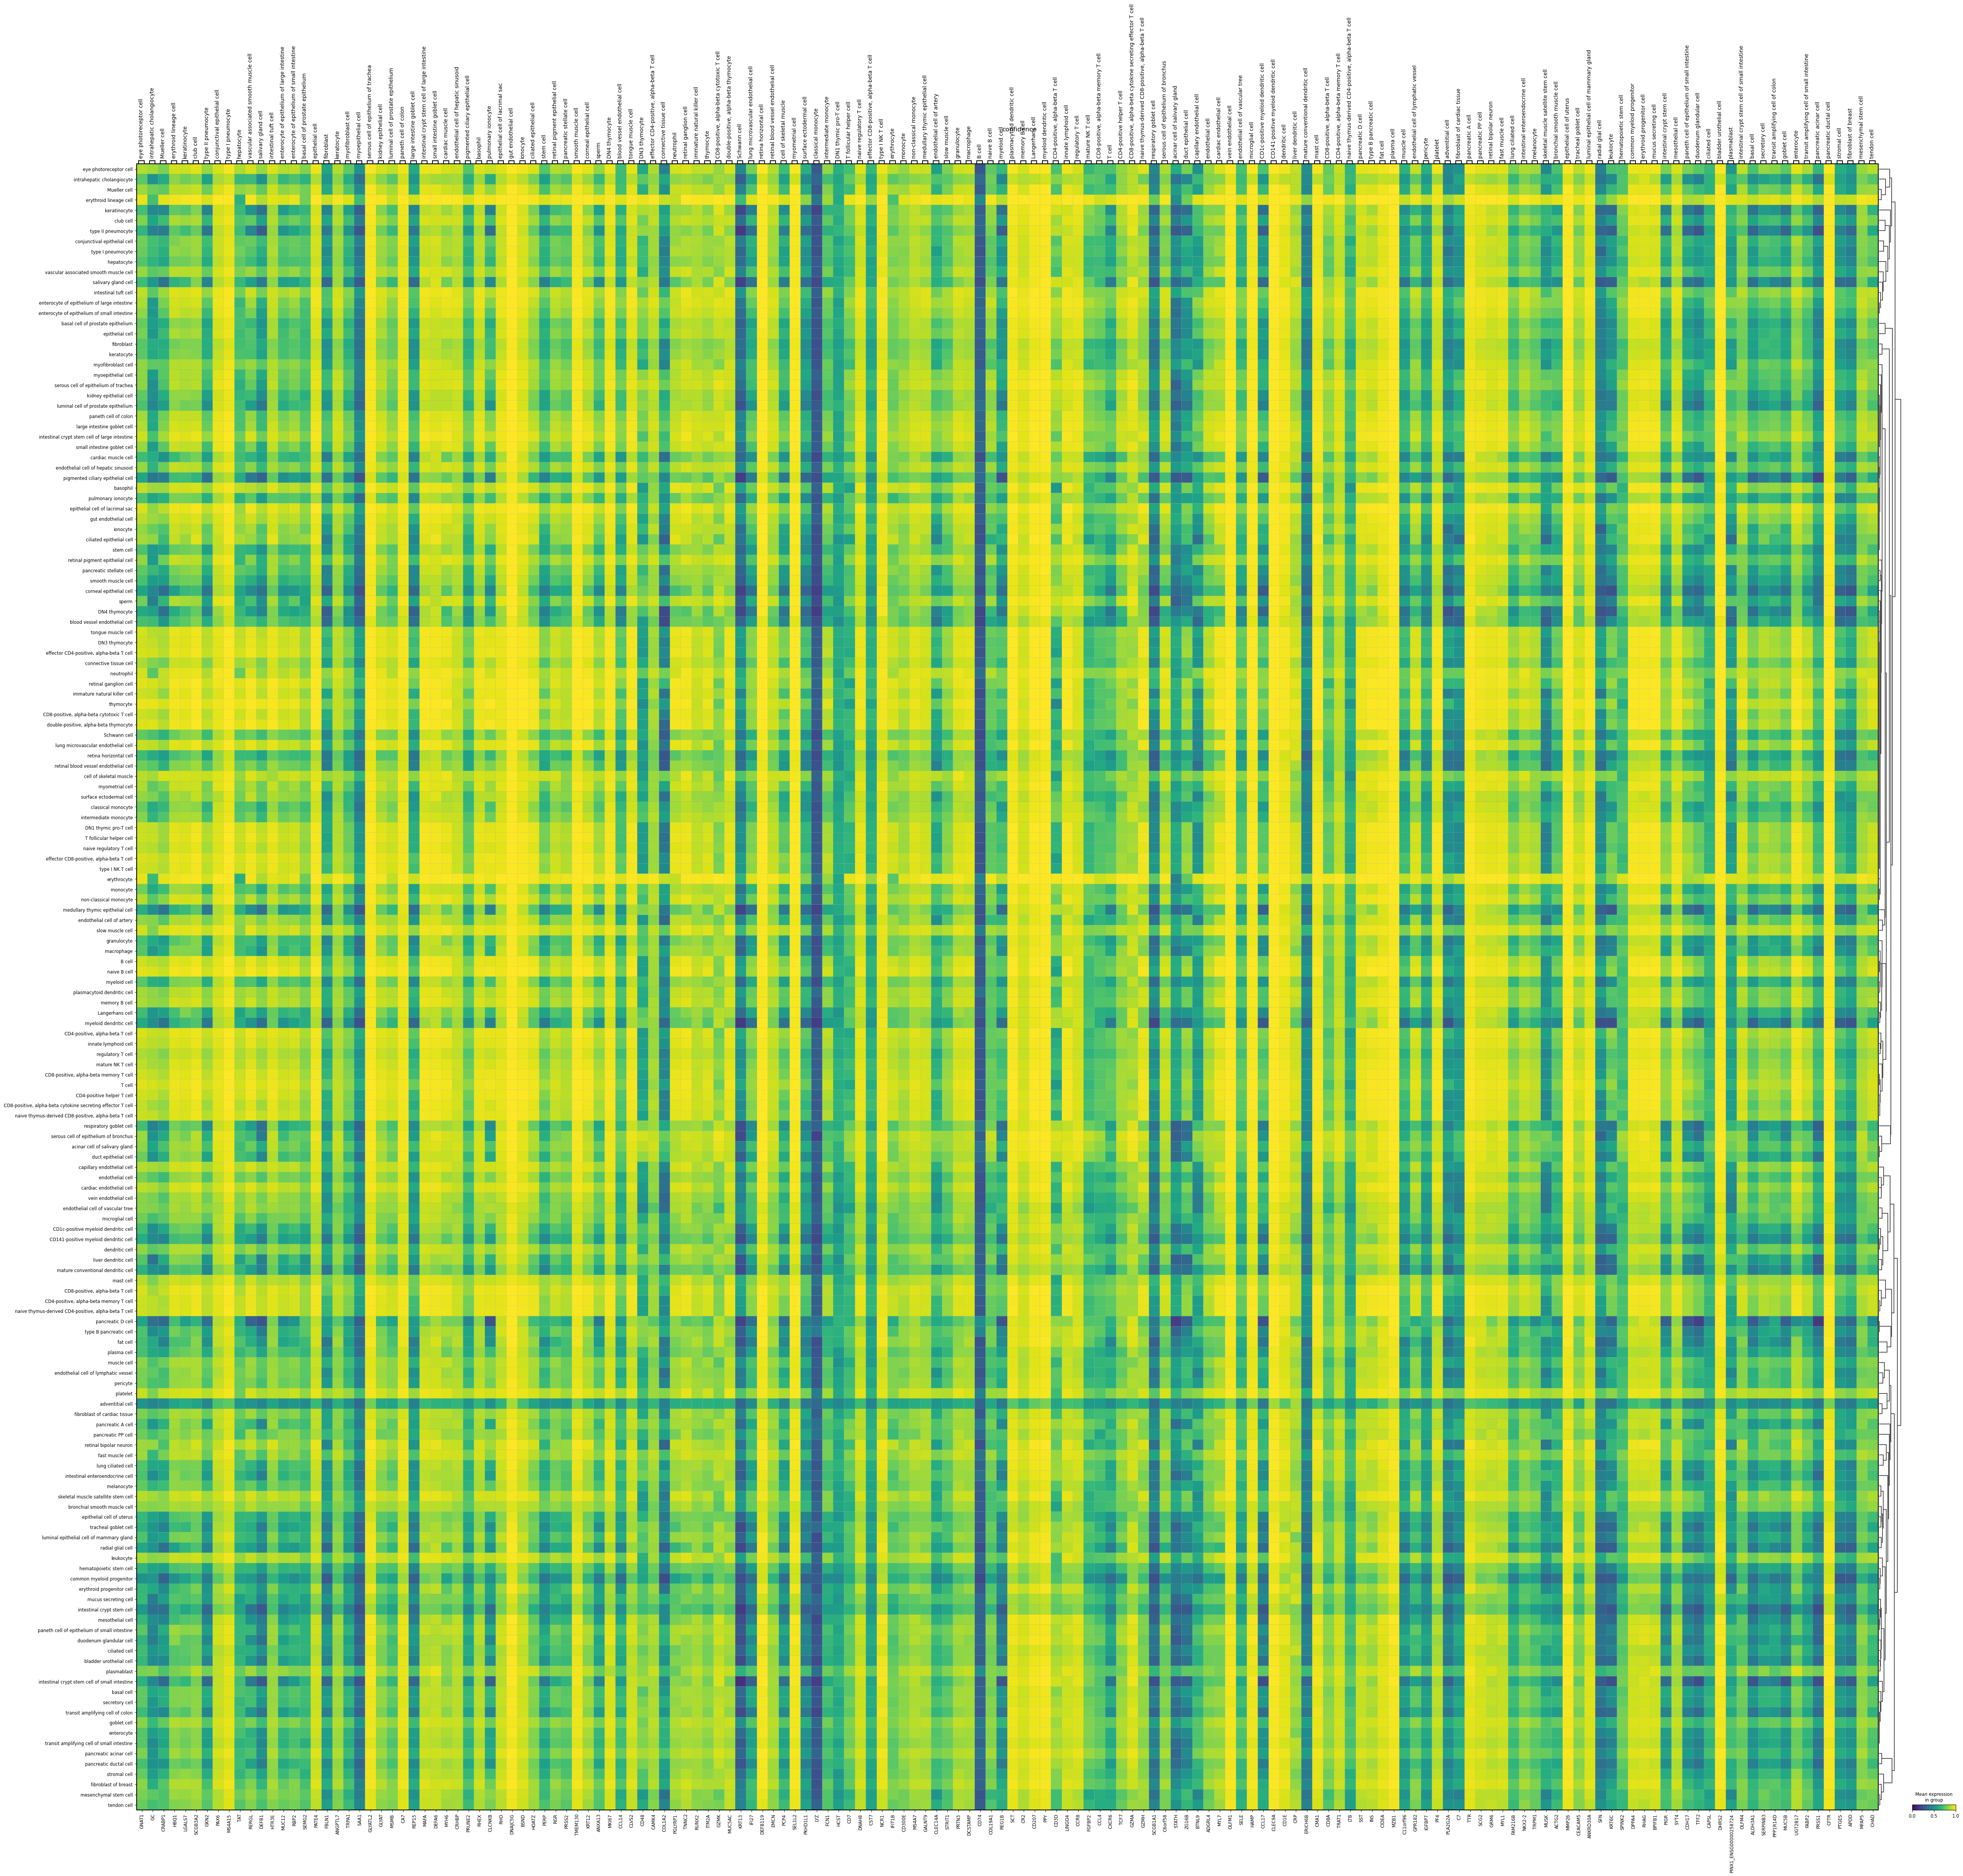

In [90]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='confidence',
    vmin=0,
    vmax=1,
    show=False,
    title='confidence',
    dendrogram=True,
)

{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

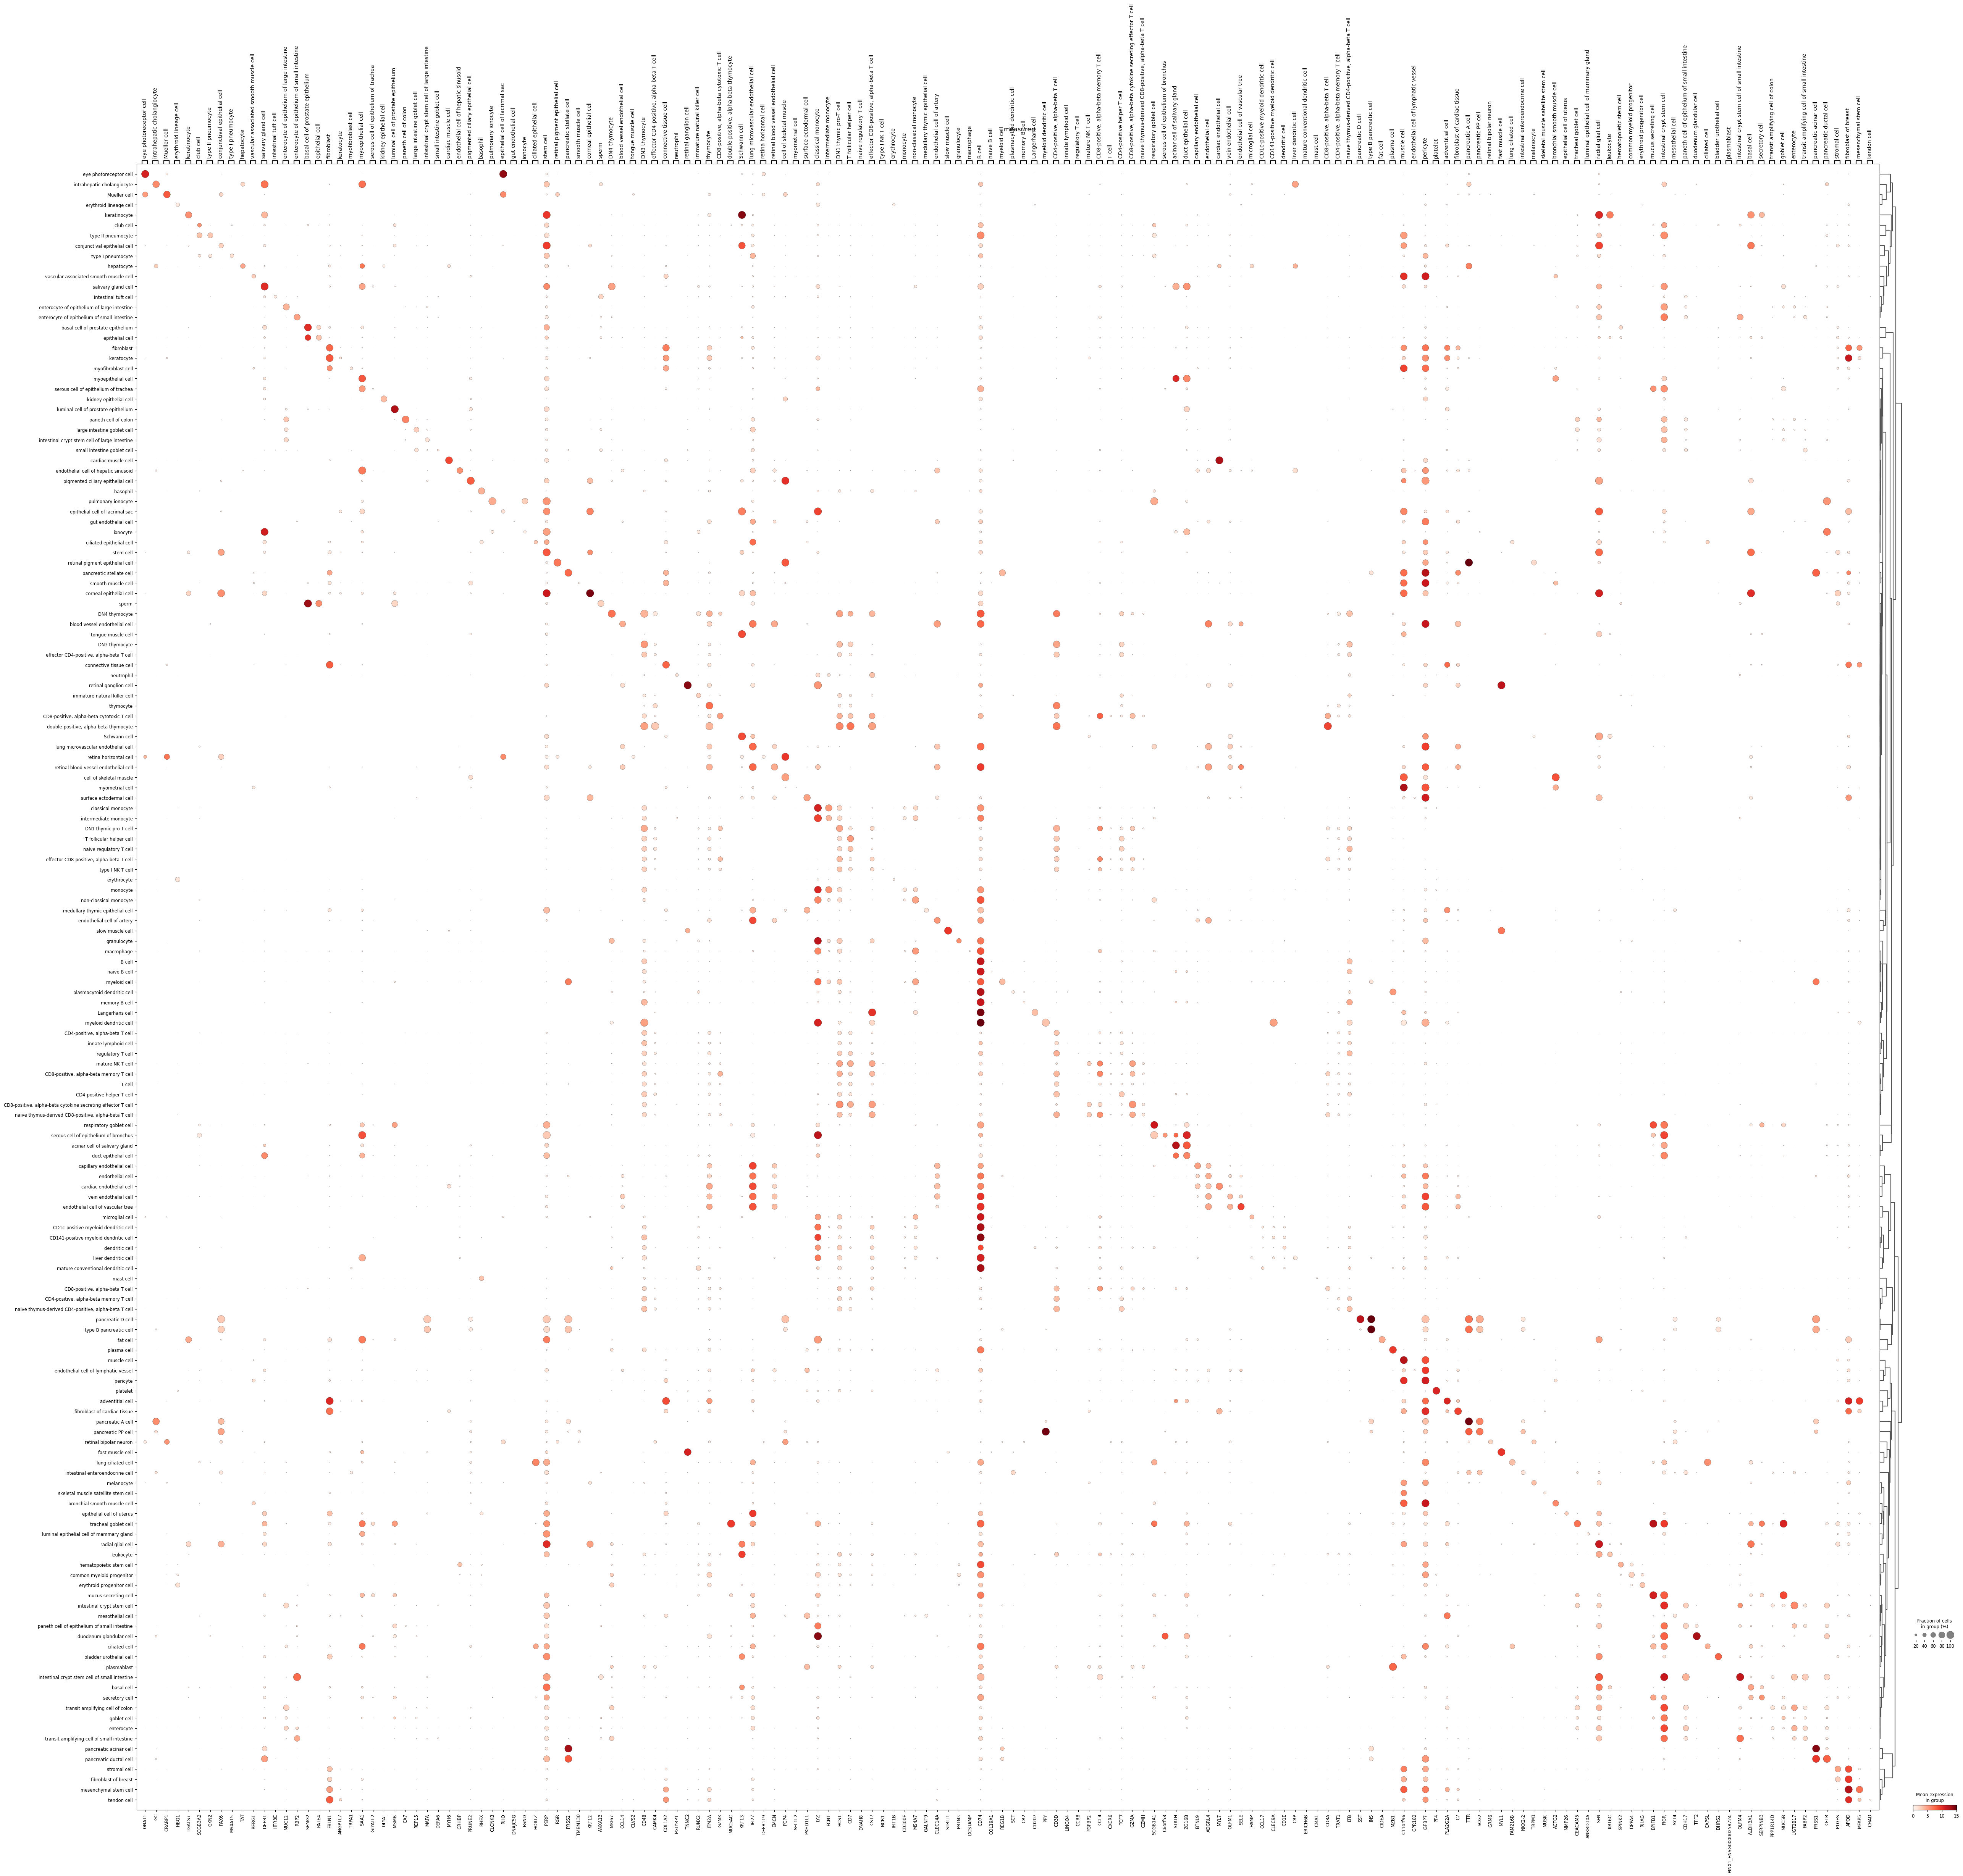

In [86]:
sc.pl.dotplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [36]:
marker_genes_dict_2 = {}

for key, value in list(marker_genes_dict.items())[:20]:
    marker_genes_dict_2[key] = value

categories: B cell, CD1c-positive myeloid dendritic cell, CD4-positive helper T cell, etc.
var_group_labels: liver dendritic cell, macrophage, monocyte, etc.


{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

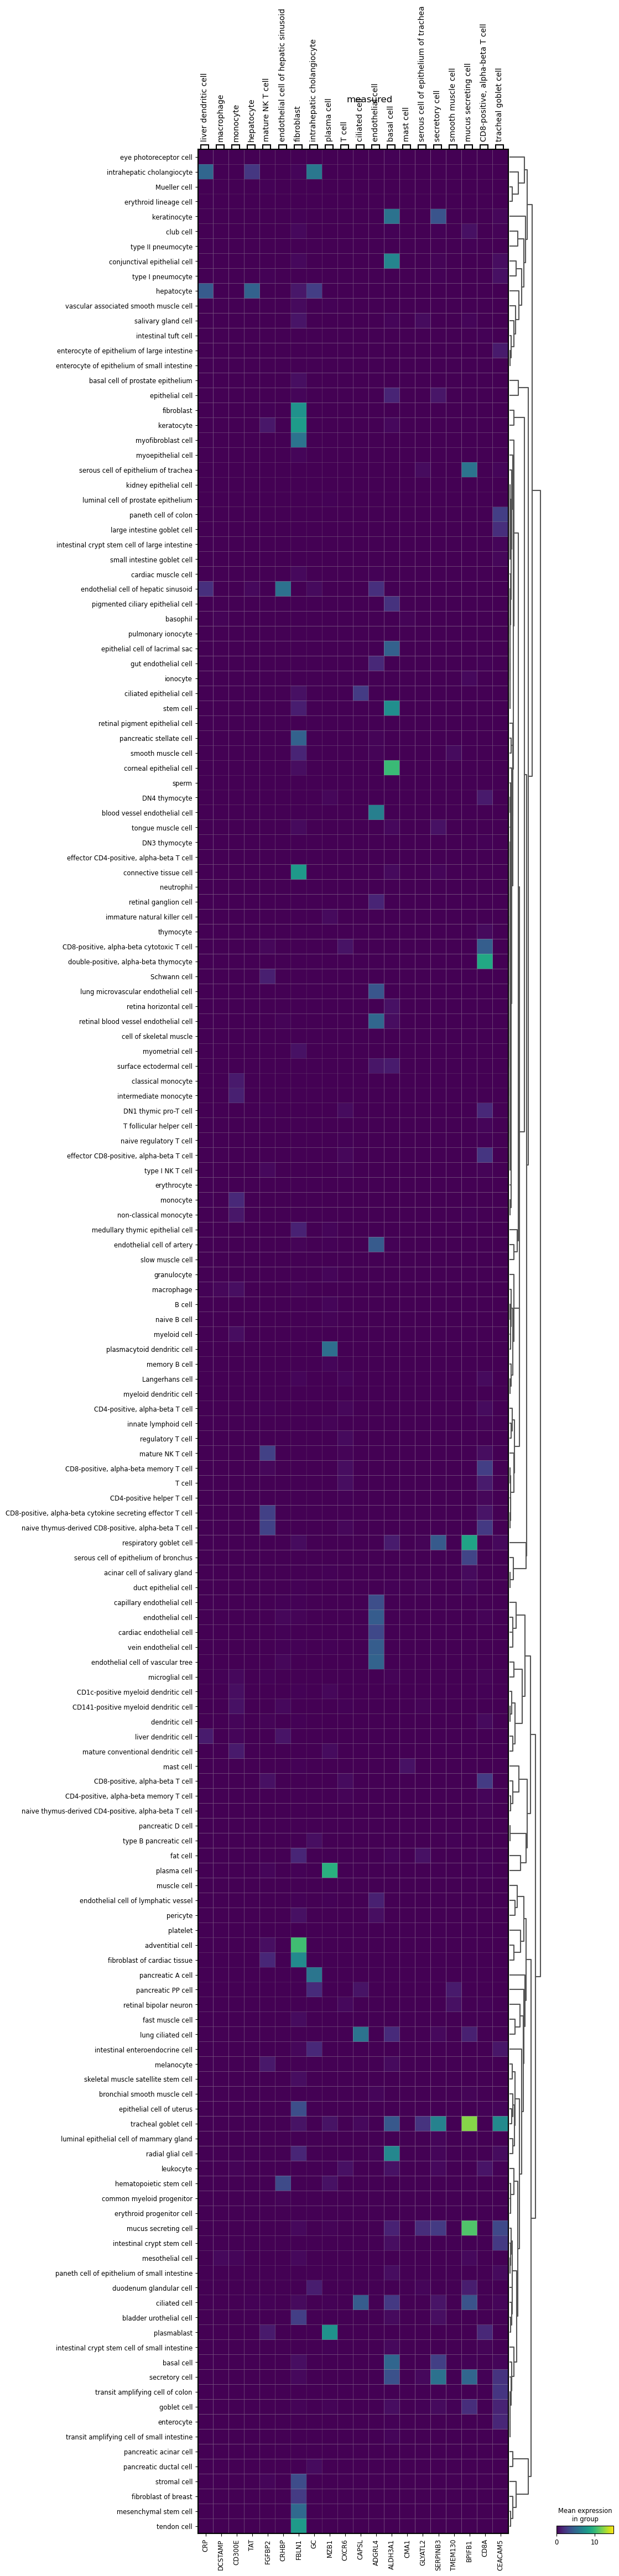

In [87]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

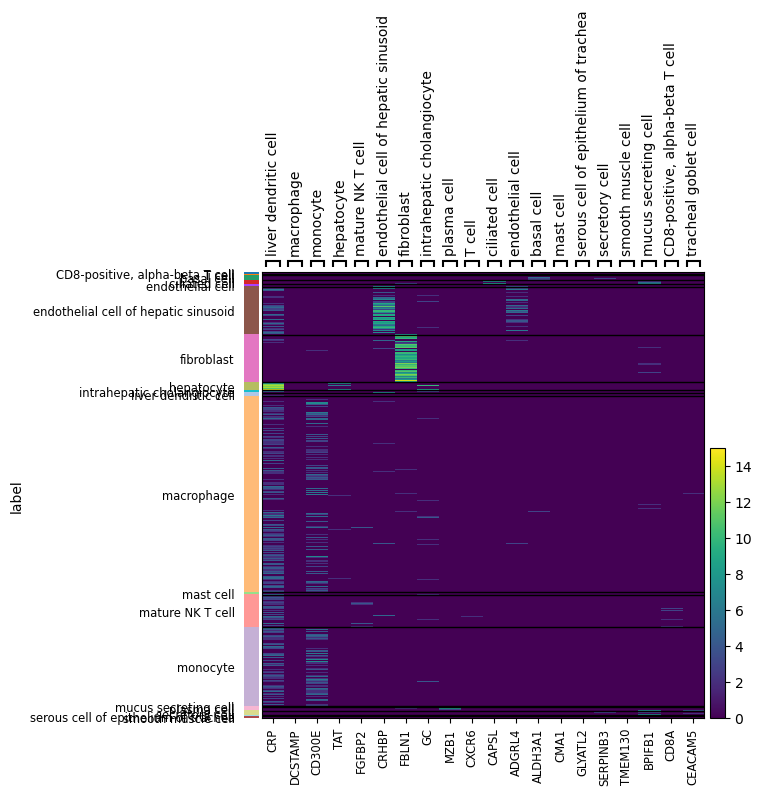

In [83]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="measured",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


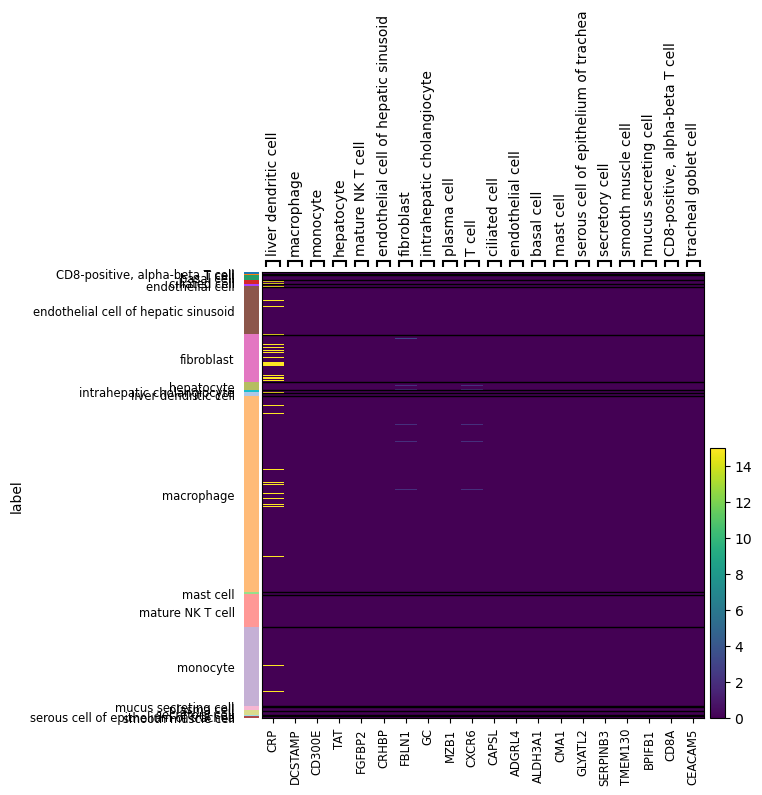

In [84]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="predicted",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [71]:
axes['heatmap_ax'].clear()

In [54]:
for a in axes['heatmap_ax'].lines:
    print(a)

TypeError: 'NoneType' object is not subscriptable

In [53]:
axes

In [18]:
del axes['gene_groups_ax']

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)